In [98]:
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
import yfinance as yf
import pandas as pd
import numpy as np
from helpers import Trade
import os

plt.style.use('Solarize_Light2')

# **Loading constants needed**

In [99]:
import json

with open('prams.json', 'r') as file:
    data = json.load(file)

WINDOW, PNL, SIGNALS, PRICE_DEVIATION, POSITIONS_NATURE, POSITIONS_SHORTCUT, FIGSIZE=data['WINDOW'], data['PNL'], data['SIGNALS'], data['PRICE_DEVIATION'], data['POSITIONS_NATURE'], data['POSITIONS_SHORTCUT'], data['FIGSIZE']

RRR = (PRICE_DEVIATION['ENTRY'] - PRICE_DEVIATION['TP'])/(PRICE_DEVIATION['SL'] - PRICE_DEVIATION['ENTRY'])

# **1. Loading & Cleaning Data**

In [100]:
if os.path.exists("data.csv"):
    df = pd.read_csv("data.csv", index_col=0)
else:
    gold_ticker = yf.Ticker("GC=F")
    df = gold_ticker.history(period="max", interval='1h')
    df.to_csv("data.csv")

df.index = pd.to_datetime(df.index, utc=True)

df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)

# display(df.shape)
# display(df.head(3))

# **2. Defining the Strategy (Mean Reversion)**

### We will create Columns needed

In [101]:
# High
df['Mean_H'] = df['High'].rolling(window=WINDOW).mean()
# df['Mean_H'] = df['High'].ewm(span=WINDOW, adjust=False).mean()
df['STD_H'] = df['High'].rolling(window=WINDOW).std()
df['Z-Score_H'] = (df['High'] - df['Mean_H']) / df['STD_H']

# Low
df['Mean_L'] = df['Low'].rolling(window=WINDOW).mean()
# df['Mean_L'] = df['Low'].ewm(span=WINDOW, adjust=False).mean()
df['STD_L'] = df['Low'].rolling(window=WINDOW).std()
df['Z-Score_L'] = (df['Low'] - df['Mean_L']) / df['STD_L']

df.dropna(inplace=True)

display(df.tail(3))

,Open,High,Low,Close,Mean_H,STD_H,Z-Score_H,Mean_L,STD_L,Z-Score_L
Datetime,,,,,,,,,,
2024-09-27 18:00:00+00:00,2667.699951,2671.500000,2665.800049,2670.399902,2683.057129,10.105944,-1.143597,2672.600028,9.131411,-0.744680
2024-09-27 19:00:00+00:00,2670.500000,2675.300049,2668.000000,2674.500000,2679.971436,8.313444,-0.561908,2670.214321,7.474477,-0.296251
2024-09-27 20:00:00+00:00,2674.300049,2682.699951,2673.600098,2680.800049,2678.414272,6.047191,0.708706,2668.371477,3.100390,1.686440


### Overview

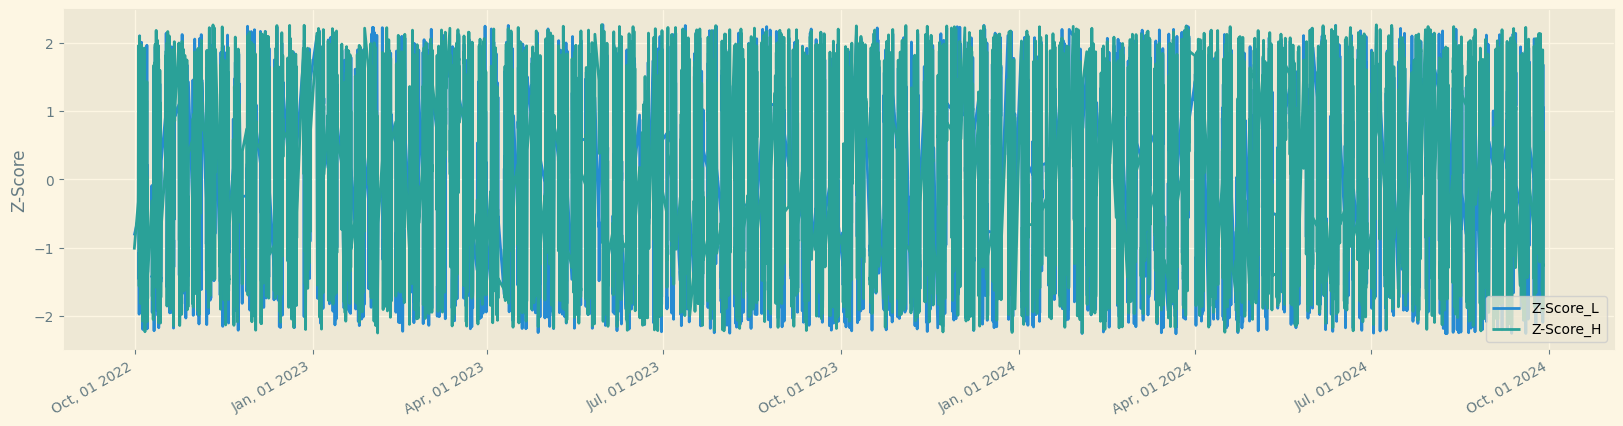

In [102]:
df[['Z-Score_L', 'Z-Score_H']].plot(kind='line', xlabel='', ylabel="Z-Score", figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT']))
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)

,Z-Score_L,Z-Score_H
max,2.267787,2.267787
min,-2.264885,-2.253863


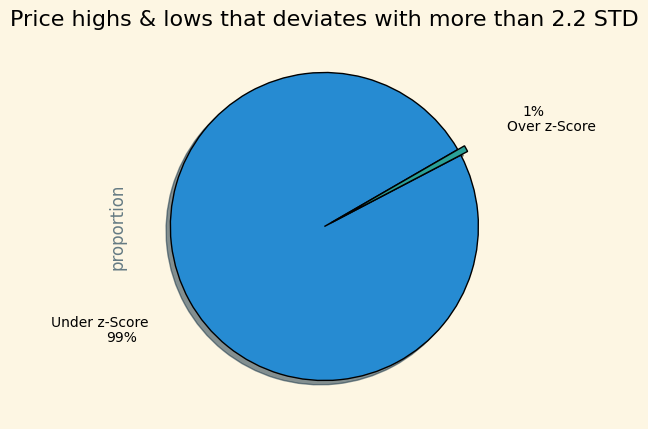

In [103]:
# same for Z-Score_H
stats = (abs(df['Z-Score_L']) > PRICE_DEVIATION['ENTRY']).value_counts(normalize=True)

stats.index = ['Under z-Score', 'Over z-Score']

stats.plot(
    kind='pie', 
    figsize=(FIGSIZE['HEIGHT'],FIGSIZE['HEIGHT']),
    title=f"Price highs & lows that deviates with more than {PRICE_DEVIATION['ENTRY']} STD",
    autopct='%1.0f%%',
    pctdistance=1.5,
    labeldistance=1.3,
    shadow=True,
    explode=[0, 0.05],
    wedgeprops={'edgecolor': 'black'},
    startangle=30
    # colors=["#ECDFCC", "#3C3D37"]
)

df[['Z-Score_L', 'Z-Score_H']].agg(['max', 'min'])

### Generate buy/sell signals

In [104]:
price_deviate_over_xSTD_filter = df['Z-Score_H'] > PRICE_DEVIATION['ENTRY']
price_deviate_under_xSTD_filter = df['Z-Score_L'] < -PRICE_DEVIATION['ENTRY']

df['Signal'] = 0  # Default to hold/no position
df.loc[price_deviate_under_xSTD_filter, 'Signal'] = SIGNALS['BUY'] # Buy signal
df.loc[price_deviate_over_xSTD_filter, 'Signal'] = SIGNALS['SELL']  # Sell signal

# [TODO] what if a candel has both signals buy and sell

# **3. Implementing Stop Loss and Take Profit**

In [105]:
df.reset_index(inplace=True)

# Initialize trade tracking columns
df['Position'] = 0  # Track if we're in a trade (1 for long, -1 for short)
df['Entry_Price'] = 0.0  # Track entry price
df['Exit_Price'] = 0.0  # Track exit price
df['PnL'] = 0.0  # Track Profit and Loss for each trade

# Simulate the strategy with SL/TP
trade = Trade()

def exit_trade(i: int, is_win: bool):
    df.loc[i, 'Exit_Price'] = trade.tp if is_win else trade.sl
    pnl = PNL['WIN'] * RRR if is_win else PNL['LOSS']
    df.loc[i, ['PnL', 'Position']] = [pnl, SIGNALS['BUY' if trade.is_buy else 'SELL']]
    return True

def is_buy_sl(i: int):
    if df.loc[i, 'Low'] <= trade.sl: return exit_trade(i, False)
    return False

def is_buy_tp(i: int, source='High'):
    if df.loc[i, source] > trade.tp: return exit_trade(i, True)
    return False

def is_sell_sl(i: int):
    if df.loc[i, 'High'] >= trade.sl: return exit_trade(i, False)
    return False

def is_sell_tp(i: int, source='Low'):
    if df.loc[i, source] < trade.tp: return exit_trade(i, True)
    return False

# [NB] check SL first then make sure trade is On to check TP

def fill_trade_params(_row, idx):
    trade_signal = _row['Signal']
    L_H = POSITIONS_SHORTCUT[str(trade_signal)]
    mean_kw, std_kw = f"Mean_{L_H}", f"STD_{L_H}"
    trade.On()
    trade.entry = (_row[mean_kw] - trade_signal * PRICE_DEVIATION['ENTRY'] * _row[std_kw])
    trade.tp = (_row[mean_kw] - trade_signal * PRICE_DEVIATION['TP'] * _row[std_kw])
    trade.sl = (_row[mean_kw] - trade_signal * PRICE_DEVIATION['SL'] * _row[std_kw])
    df.loc[idx, ['Position', 'Entry_Price']] = [trade_signal, trade.entry]

    # check if sl or tp is already hit in the same candel (i)
    if trade_signal == SIGNALS['BUY']:
        if is_buy_sl(idx): trade.Off()
        elif is_buy_tp(idx, source='Close'): trade.Off()
    elif trade_signal == SIGNALS['SELL']:
        if is_sell_sl(idx): trade.Off()
        elif is_sell_tp(idx, source='Close'): trade.Off()

# Loop through candles and execute trades
for i, row in df.iterrows(): # row for reading, i for writing
    if trade.on: 
        # Track price movement for Stop Loss or Take Profit
        if trade.is_buy: 
            if is_buy_sl(i): trade.Off()
            elif is_buy_tp(i, source='Close'): trade.Off()
        elif trade.is_sell:
            if is_sell_sl(i): trade.Off()
            elif is_sell_tp(i, source='Close'): trade.Off()
    else:
        if row['Signal'] != 0: # Check if there's a signal
            fill_trade_params(row, i)

# **4. Backtesting & Overview**

In [106]:
# Calculate cumulative profit/loss
df['Cumulative_PnL'] = df['PnL'].cumsum()

# Filter rows where we had a trade exit
trades = df[df['PnL'] != 0]

# Summary statistics
total_trades = len(trades)
total_pnl = df['Cumulative_PnL'].iloc[-1]  # Total profit/loss
PnL = trades['PnL'].value_counts(normalize=True)
win_rate = 0

if not PnL.empty:
    win_rate = PnL[PnL.index > 0].iloc[0]

expectency = (RRR + 1) * win_rate - 1

strategy_stats_df = pd.DataFrame(
    np.array([[
        total_trades,
        total_pnl,
        round(win_rate * 100, 2),
        RRR,
        expectency,
        expectency * total_trades
    ]]),
    columns=['Total Trades', 'Total Profit/Loss (RR)', 'Win rate (%)', 'Risk-Reward Ratio', 'Expectancy', 'Expected return'],
    index=['Metrics']
)

strategy_stats_df

,Total Trades,Total Profit/Loss (RR),Win rate (%),Risk-Reward Ratio,Expectancy,Expected return
Metrics,91.0,74.625,58.24,2.125,0.820055,74.625


In [107]:
strategy_stats_df.to_csv("results.csv")

- **PnL**

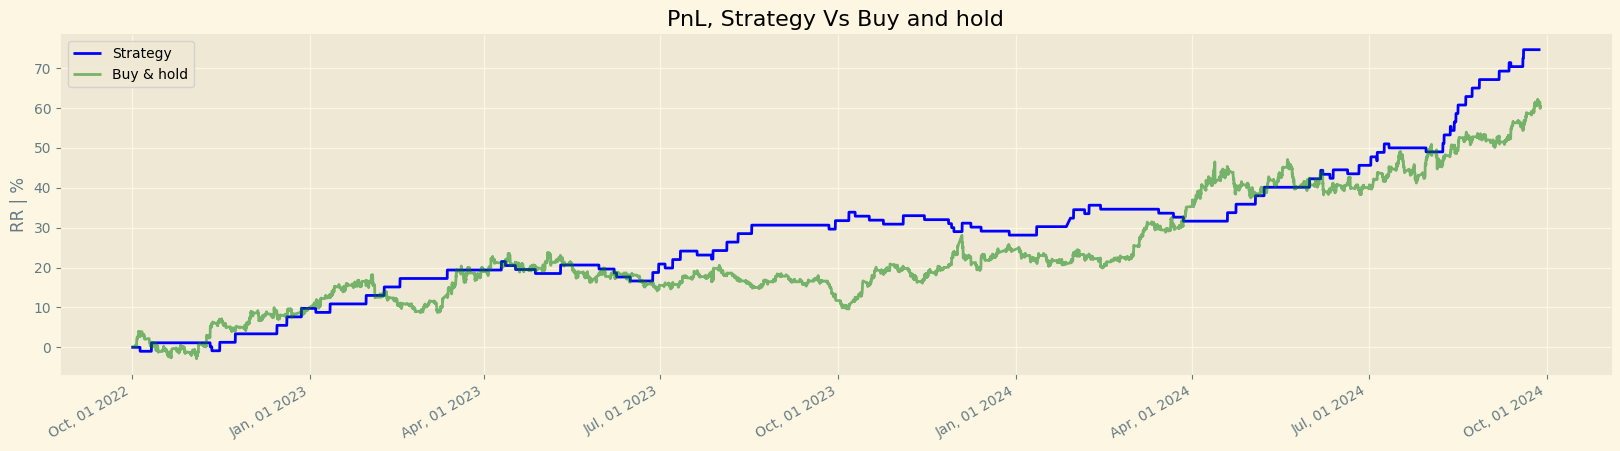

In [108]:
df.set_index('Datetime', inplace=True)

starting_inv_price = df['Close'].iloc[0]


# Plot the Strategy returns
df['Cumulative_PnL'].plot(
        label='Strategy', 
        figsize=(FIGSIZE['WIDTH'], 
        FIGSIZE['HEIGHT']), 
        color='blue', 
        xlabel='',
        ylabel='RR | %'
    )

(100 * (df['Close'] - starting_inv_price)/starting_inv_price).plot(
        label='Buy & hold', 
        figsize=(FIGSIZE['WIDTH'], 
        FIGSIZE['HEIGHT']), 
        color='green', 
        xlabel='',
        alpha=.5,
        ylabel='RR | %'
    )

plt.title('PnL, Strategy Vs Buy and hold')
plt.legend()

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)

- **PnL-Drawdown** (not from Equity)

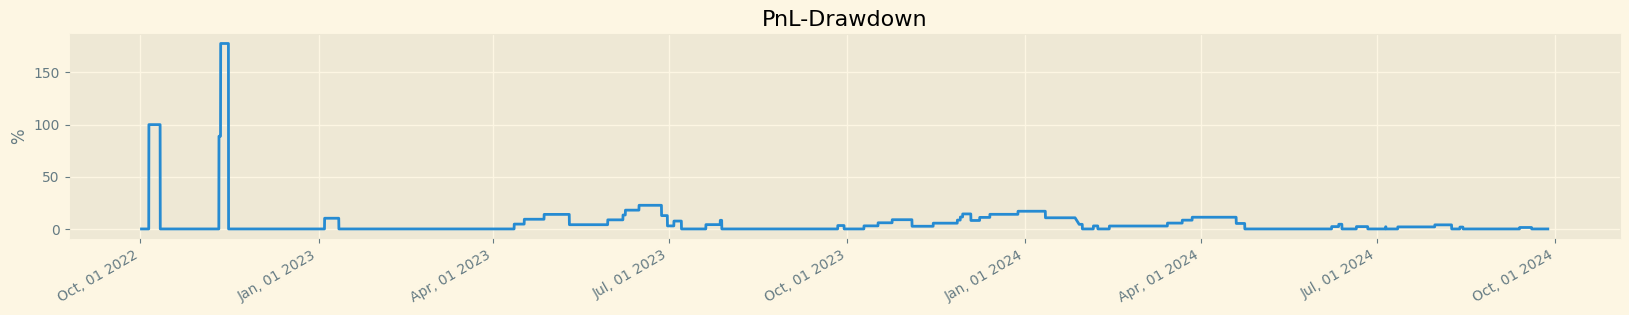

In [109]:
df['Peak'] = df['Cumulative_PnL'].cummax()

# df['Drawdown'] = (df['Peak'] - df['Cumulative_PnL']) / abs(df['Peak'])
df['Drawdown'] = np.where(df['Peak'] == 0, abs(df['Cumulative_PnL']), (df['Peak'] - df['Cumulative_PnL']) / df['Peak'])

# df['Drawdown'] = df.apply(lambda row: ((row['Peak'] - row['Cumulative_PnL']) / row['Peak']) if row['Peak'] != 0 else 0, axis=1)
# df['Drawdown'] = np.where(df['Peak'] != 0, (df['Peak'] - df['Cumulative_PnL']) / df['Peak'], 0)

(df['Drawdown'] * 100).plot(
    kind='line', 
    figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT'] - 2),
    title="PnL-Drawdown",
    ylabel="%",
    xlabel=''
)

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)

In [110]:
print(f"Max PnL-drawdown is {round(100 * df['Drawdown'].max(), 2)} %")

Max PnL-drawdown is 177.78 %


# **5. Overview on positions**

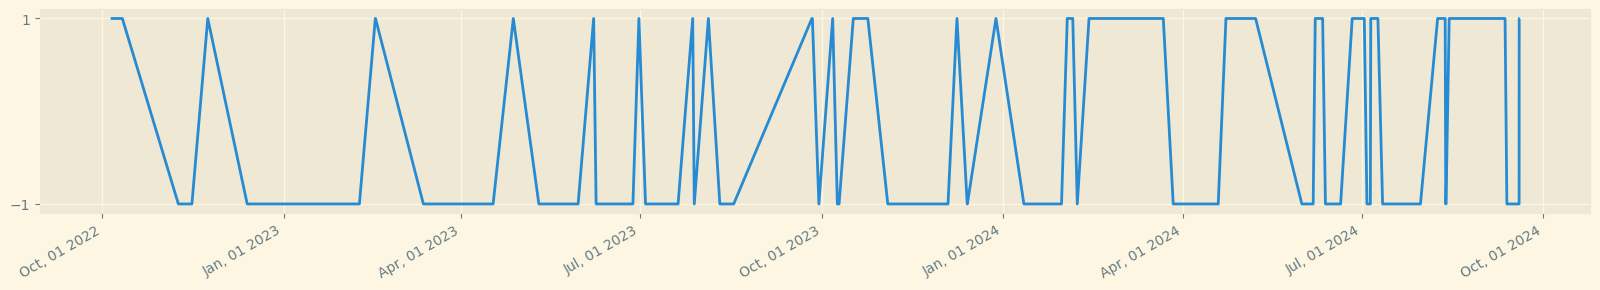

In [111]:
filtrty = df['Position'] != 0

df.loc[filtrty, 'Position'].plot(kind='line', figsize=(FIGSIZE['WIDTH'],FIGSIZE['HEIGHT'] - 2), xlabel='', yticks=[-1, 1])

plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)

<Axes: title={'center': 'Positions nature distribution'}, ylabel='proportion'>

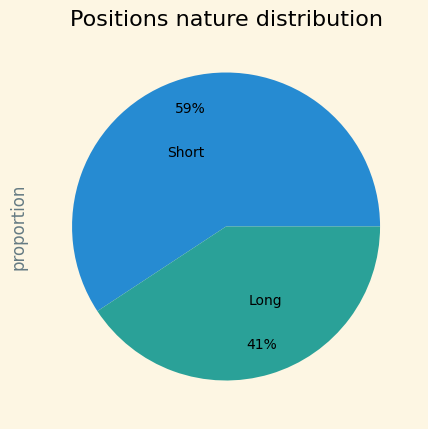

In [112]:
positions_nature_distribution_df = df.loc[filtrty, 'Position'].value_counts(normalize=True)

positions_nature_distribution_df.index = [POSITIONS_NATURE[str(x)] for x in positions_nature_distribution_df.index.to_list()]

positions_nature_distribution_df

positions_nature_distribution_df.plot(
    kind='pie', 
    figsize=(5, 5),
    title="Positions nature distribution",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.5
)

# [TODO] probability distribution

<Axes: title={'center': 'Percentage of Long & Short from losing positions'}, ylabel='proportion'>

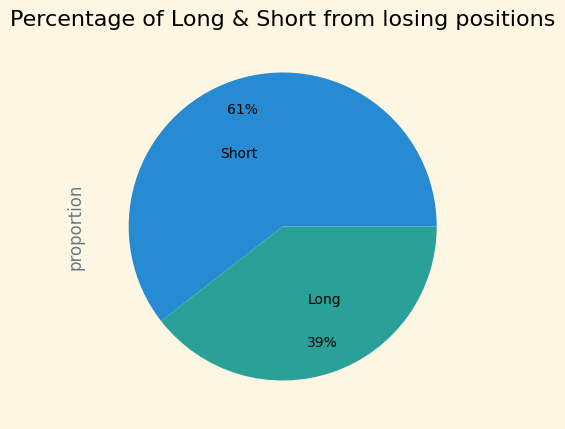

In [113]:
losing_positions_sr = df.loc[df['PnL'] == -1, 'Position'].value_counts(normalize=True)

losing_positions_sr.index = [POSITIONS_NATURE[str(x)] for x in losing_positions_sr.index.to_list()]

losing_positions_sr.plot(
    kind='pie', 
    figsize=(5, 5),
    title="Percentage of Long & Short from losing positions",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.5
)

In [114]:
# [TODO] max consecutive wins & losses (so we can avoid drawdown)

# **6. A study on Drawdown**